# Twitter analysis in USA location of roofing related twitter text for identifying business opportunity

## This notebook describes steps from twitter data extraction for last 4 days and build ML model to identify some important topics and display those.

#### We find out 10 most important topic people are talking about. For each topic we try to find most important words. By showing those words we might get an idea on what people are talking about and that in turns might help business for taking some decisions.


## Import required python libraries

In [1]:
import tweepy
from datetime import datetime, timedelta
import time
import twitter
from tweepy import Stream
from tweepy import OAuthHandler
from tweepy.streaming import StreamListener
import json
import pandas as pd
import csv
import re #regular expression
from textblob import TextBlob
import string
import preprocessor as p
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import os.path
pd.options.display.max_colwidth = 500
import collections
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import numpy as np
import pyLDAvis.sklearn
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import LatentDirichletAllocation as LDA
import pyLDAvis
import pyLDAvis.gensim  
from pprint import pprint
import gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

C:\Users\suman12345678\Anaconda3\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


## Parameter inputs from users

#### With the below parameters this script will download twitter data with the keywords mentioned in 'searchQuery' and in between date 'since' and 'endUntil'.  for each date download 'maxTweets' no of records

#### As we are usng free tweeter API, sometimes this API doesnot allow us get data and cause sleeping for few minutes. 

#### With this api we cannot filter data with searchstring and location together directly. We can download whole data and later filter on location. We cannot get twitter data older than 7 days freely. We can mention all USA city in 'usa_locations' 

#### First time the download data will be saved as 'file_to_save' in directoryname 'dirname'. User can visualize top 'display_n_words' number of words 

In [59]:
# Twitter app credentials
consumer_key = 'naORWAQMry8zaFS3ToC5nkq61'
consumer_secret = 'wbDkwSYLXeduvCEKgOOkBye8WAwhr43Lxgg97wSH9hC1mROLiB'
access_token = '1251008034546974725-ANo5Zzq8jZaKbYpEt0gMh0IJQQ1Nrf'
access_secret = '26EXNB1T8JqWVM0j0PogmvsXMoMGHjMpFdvUzasL4hBaP'

# Tweet extraction criteria
maxTweets = 40000 # Some arbitrary large number, after 16000 its giving connection error
tweetsPerQry = 100  # this is the max the API permits
endUntil = '2020-04-20'  #till date tweet should be downloaded
since = '2020-04-16'  #since date
#"covid" OR "coronavirus" OR "covid-19" OR "virus"
# tweets containing texts to be downloaded
searchQuery = '"#Roofing" OR "#roofing" OR \
               "#RoofingExpo"  OR "#RoofingContractors" OR "#roofing" OR "roof" OR "roofers" \
               OR "building" OR "shingles"'      #OR "TPO" OR "PVC" OR "SBS" OR "#TPA"'
lan='en'  #language
# name of the downloaded csv file
file_to_save='twitterdata.csv'
# directory where tweet tobe saved
dirname=r'C:\Users\suman12345678\Desktop\twitter\test\\'
# Some words are dominating in twitter world ignore them like covid-19
excludewords = ["quarntine","quarantine","covid","coronavirus","covid19","covid-19","virus","coronavirus","wuhan","corona","china","lockdown","quarntine","pandemic","helth","trump"]

# Data cleanning: words to ignore
mystopwords=['rt','https','cc']

# Visualize top n words 
display_n_words=15

# user_location sometimes city, state, country, Please add here all important city to include in filtering
usa_locations=['United States','USA',
'Alabama','AL','Montana','MT',
'Alaska','AK','Nebraska','NE',
'Arizona','AZ','Nevada','NV',
'Arkansas','AR','New Hampshire','NH',
'California','CA','New Jersey','NJ',
'Colorado','CO','New Mexico','NM',
'Connecticut','CT','New York','NY',
'Delaware','DE','North Carolina','NC',
'Florida','FL','North Dakota','ND',
'Georgia','GA','Ohio','OH',
'Hawaii','HI','Oklahoma','OK',
'Idaho','ID','Oregon','OR',
'Illinois','IL','Pennsylvania','PA',
'Indiana','IN','Rhode Island','RI',
'Iowa','IA','South Carolina','SC',
'Kansas','KS','South Dakota','SD',
'Kentucky','KY','Tennessee','TN',
'Louisiana','LA','Texas','TX',
'Maine','ME','Utah','UT',
'Maryland','MD','Vermont','VT',
'Massachusetts','MA','Virginia','VA',
'Michigan','MI','Washington','WA',
'Minnesota','MN','West Virginia','WV',
'Mississippi','MS','Wisconsin','WI',
'Missouri','MO','Wyoming','WY']


## Download data using twitter REST api
#### This script will download record and save in the drive mentioned above first time. If the file exist script will use it and wont download data again

In [60]:
def create_api(consumer_key=consumer_key,consumer_secret=consumer_secret,access_token=access_token,access_secret=access_secret):

   auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
   auth.set_access_token(access_token, access_secret)
   api = tweepy.API(auth,wait_on_rate_limit=True,wait_on_rate_limit_notify=True)
   try:
        api.verify_credentials()
        #print('hi')
   except Exception as e:
        print('Please provide correct key',e)
   return api     
        
def get_data(api,searchQuery=searchQuery,endUntil=endUntil,lan=lan,file_to_save=file_to_save, dirname=dirname,fname=file_to_save):

    # If results from a specific ID onwards are reqd, set since_id to that ID.
    # else default to no lower limit, go as far back as API allows
    sinceId = None

    # If results only below a specific ID are, set max_id to that ID.
    # else default to no upper limit, start from the most recent tweet matching the search query.
    max_id = -10000

    tweetCount = 0
    tweets=[]
    print("Downloading max {0} tweets".format(maxTweets))
    while tweetCount < maxTweets:
        try:
            # refer: https://bhaskarvk.github.io/2015/01/how-to-use-twitters-search-rest-api-most-effectively./
            if (max_id <= 0):
                if (not sinceId): # first time
                    new_tweets = api.search(q=searchQuery, count=tweetsPerQry, until=endUntil,lang=lan, result_type='recent',wait_on_rate_limit=True, wait_on_rate_limit_notify=True ) #, since=startSince)
                else:
                    new_tweets = api.search(q=searchQuery, count=tweetsPerQry, until=endUntil,lang=lan, result_type='recent',wait_on_rate_limit=True, wait_on_rate_limit_notify=True,  #,since=startSince,
                                            since_id=sinceId)
            else:
                if (not sinceId):
                    new_tweets = api.search(q=searchQuery, count=tweetsPerQry, until=endUntil,lang=lan, result_type='recent',wait_on_rate_limit=True, wait_on_rate_limit_notify=True,  #,since=startSince,
                                            max_id=str(max_id - 1))
                else:
                    new_tweets = api.search(q=searchQuery, count=tweetsPerQry, until=endUntil,lang=lan, result_type='recent',wait_on_rate_limit=True, wait_on_rate_limit_notify=True,  #,since=startSince, 
                                            max_id=str(max_id - 1),
                                            since_id=sinceId)
            if not new_tweets:
                print("No more tweets found")
                break
                
            for tweet in new_tweets:
                #print('\n\n\n',tweet)
                placeHolder = []
                placeHolder.append(tweet.author.name.encode('utf8'))
                placeHolder.append(tweet.author.screen_name.encode('utf8'))
                placeHolder.append(tweet.created_at)
                placeHolder.append(tweet.text)

                try:
                    placeHolder.append(tweet.place.full_name)
                    placeHolder.append(tweet.place.country)
                    placeHolder.append(tweet.place.place_type)
                except:
                    placeHolder.append('')
                    placeHolder.append('')
                    placeHolder.append('')

                placeHolder.append(tweet.user.location)
                placeHolder.append(tweet.geo)

                tweets.append(placeHolder)

            tweetCount += len(new_tweets)
            print("Downloaded {0} tweets".format(tweetCount))
            max_id = new_tweets[-1].id
        #except tweepy.TweepError as e:
        #    print("some error : " + str(e))
        #    break
        # refer: https://stackoverflow.com/questions/21308762/avoid-twitter-api-limitation-with-tweepy
        except tweepy.TweepError as e:
            #time.sleep(60 * 2)
            print('continuing after waiting...')
            continue
        except StopIteration:
            break

    data=pd.DataFrame(data=tweets, columns=['Author','Screenname','Created','text','place_name','country','place_type','user_location','user_geo_loc'])
    #data.to_csv(dirname+file_to_save)
    return data

api=create_api(consumer_key=consumer_key,consumer_secret=consumer_secret,access_token=access_token,access_secret=access_secret)

if os.path.isfile(dirname+file_to_save):
       final_data=pd.read_csv(dirname+file_to_save)
       print('Already file available',final_data.shape)
else:   
    cur_extract=endUntil
    final_data=pd.DataFrame()
    while(cur_extract>=since):
        print('extract',cur_extract)
        data=get_data(api=api,searchQuery=searchQuery,endUntil=cur_extract,lan=lan,file_to_save=file_to_save, dirname=dirname)
        print(data.shape)
        cur_extract=(datetime.strptime(cur_extract,'%Y-%m-%d') - timedelta(days=1)).strftime('%Y-%m-%d')
        final_data=pd.concat([final_data,data])
    final_data.to_csv(dirname+file_to_save)    
  
    
#data=get_data(api=api,searchQuery=searchQuery,endUntil=endUntil,lan=lan,file_to_save=file_to_save, dirname=dirname)

Already file available (200291, 12)


In [61]:
#final_data=pd.read_csv(dirname+'twitterdata_old.csv')
#final_data.shape
#final_data=final_data.drop_duplicates(list(final_data.columns))
#final_data.to_csv(dirname+file_to_save)
#endUntil = '2020-04-20'  #till date tweet should be downloaded
#since = '2020-04-16'  #since date

#cur_extract=endUntil
#while(cur_extract>=since):
#    print('extract',cur_extract)
#    cur_extract=(datetime.strptime(cur_extract,'%Y-%m-%d') - timedelta(days=1)).strftime('%Y-%m-%d')


#### Raw data statistics

In [62]:
print('Total no of data',final_data.shape[0])
print('No of data where user location available',sum(list(final_data['user_location'].value_counts())))
#print('No of data where user location United States',final_data[final_data['user_location']=='United States']['user_location'].value_counts()[0])
print('No of data where user location United States',final_data[final_data.user_location.str.contains('|'.join(usa_locations),na=False)].shape[0])
print('No of unique text ',final_data.drop_duplicates(['text']).shape[0])
unique_text=final_data.drop_duplicates(['text'])
print('No of texts with roof in unique text',unique_text[unique_text.text.str.contains('|'.join(['roof']))].shape[0])

Total no of data 200291
No of data where user location available 140887
No of data where user location United States 58652
No of unique text  90761
No of texts with roof in unique text 11424


In [63]:
#list(data['user_location'].value_counts().index)


## Apply required extra filter on downloaded data from twitter
#### Filter data where user_location 'USA' 


In [64]:
#places = api.geo_search(query="USA", granularity="country")
#place_id = places[0].id
#data[data['user_location'].isin(['United States','',None])].shape
#df = df[df['EPS'].notna()]
#print(final_data[final_data['user_location'].notna()].shape)
# filter only usa data
final_data=final_data[final_data.user_location.str.contains('|'.join(usa_locations),na=False)]
print(final_data.shape)

(58652, 12)


In [65]:
# we can get only last 1 week data
#temp=data.copy()
#temp['Created_dt']=temp['Created'].apply(lambda x: pd.to_datetime(x).date())
#temp=temp[temp['Created_dt'].astype('str')=='2020-04-19']
#temp=temp.drop_duplicates(subset={'text'})

## Cleanning text data before getting insights

In [66]:
# Display one duplicate
print(final_data.sort_values('text')['text'][:5])  # some instances of duplicate
print('no of unique sentences',len(final_data['text'].unique()))

50122     " Education for regenerative cultures is about the life-long process of enabling and building the capacity of every… https://t.co/5HZ9CTGW8T
62382        " you wouldn't. the building which i currently take residence has enough accommodations to house a hundred men. " https://t.co/4LQEW8l40y
94514     "'Animal Crossing’ is an opportunity for a person to create a new society on a deserted island and to kind of creat… https://t.co/G8tPmUARLm
89859     "...Alkira’s team has the ambitious vision to disrupt the status quo, and a proven track record building enduring c… https://t.co/g403mxm2NT
100961     "...the Commons are living systems to meet shared needs. As old as humanity itself and as new as the latest trends… https://t.co/ePHdTpYzIQ
Name: text, dtype: object
no of unique sentences 31242


#### Remove duplicate text, convert to lowercase, create a column with the hashtag used

In [67]:
# Drop duplicate
textdata=final_data.drop_duplicates(subset={'text'})
print(textdata.shape)

textdata=textdata.copy()

#convert to lower
textdata['text']=textdata['text'].apply(lambda x: x.lower()).copy()

# find hashtag
textdata['tag']=textdata['text'].apply(lambda x: re.findall(r"#(\w+)", x)).copy()

l=textdata['text'].str.lower().str.split().tolist()
print('No of unique words',len(set([item for sublist in l for item in sublist])))

(31242, 12)
No of unique words 100831


In [68]:
# remove words covid related as those are dominating string
textdata=textdata.copy()
textdata = textdata[~textdata.text.str.contains('|'.join(excludewords))]
print('Shape of df',textdata.shape)                    

Shape of df (28983, 13)


In [69]:
textdata['text'].head(5)

0        @itsafez66 last week i heard fireworks forever and was like jfc calm down but then i got a citizen alert and it tur… https://t.co/grgcsdef5c
1        simply put, they are the actual building blocks of that wardrobe you’ve been dreaming about. they are actually thos… https://t.co/h4fphksn5a
4         rt @naval: the swedish approach allows us to measure the cost of building herd immunity using partial and voluntary measures rather than a…
6                                                                                               rt @lexp__: oh shit y’all mrs. niggas in the building
13    rt @tayuface: "never ask a vampire for a favor.  :f"\n\n"don't get involved with wizards.  -_-"\n\n"always pay attention to what, exactly, the…
Name: text, dtype: object

#### Remove website names, remove the names whome text was retweeted, removed punctuations, digits, removed english stopwords, kept only alphabetic chracters, used lemmetization(original form of words : cats--> cat)

In [70]:
textdata=textdata.copy()

#remove website name
textdata['text']=textdata['text'].apply(lambda x: re.sub(r'https?:\/\/.*[\r\n]*', '', x, flags=re.MULTILINE))
                                        
#remove RT retweet to subject
textdata['text']=textdata['text'].apply(lambda x: re.sub(r'@(\w+)', r'', x))

# clean punc
def cleanpuncdigit(sentence):
    #cleaned=re.sub(r'[-|[|]|.|,|:|\|/|?|!|\'|"|#]',r' ',sentence)
    cleaned=re.sub(r'[-|\|(|)|.|,|:|/|?|!|\'|"|#]',r' ',sentence)
    cleaned=re.sub(r'[\d+]',r' ',cleaned)    
    return cleaned
textdata['text']=textdata['text'].apply(cleanpuncdigit)

#remove stopwords
stop=set(stopwords.words('english'))
stop.update(mystopwords)
textdata['text']=textdata['text'].apply(lambda x : ' '.join([item for item in x.split() if item not in stop]))

l=textdata['text'].str.lower().str.split().tolist()
print('No of unique words before stem',len(set([item for sublist in l for item in sublist])))

# Stemming this is not giving correct words so commenting
#sno=nltk.stem.snowball.SnowballStemmer('english')
#textdata['text'] = textdata['text'].apply(lambda x: ' '.join([sno.stem(y) for y in x.split()])) # Stem every word.
#sno.stem('coming come programers programer, programming going')

l=textdata['text'].str.lower().str.split().tolist()
print('No of unique words after stemming',len(set([item for sublist in l for item in sublist])))

# keep only alphabetic character remove whitespace
textdata['text']=textdata['text'].apply(lambda x: re.sub(r'[^A-Za-z]', ' ', x))
textdata['text']=textdata['text'].apply(lambda x: x.strip())

# Lemmetization we are removing for now
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()
def lemmatize_text(text):
    return ' '.join([lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)])
#textdata['text']=textdata['text'].apply(lemmatize_text)

l=textdata['text'].str.lower().str.split().tolist()
print('No of unique words after lemetization',len(set([item for sublist in l for item in sublist])))

No of unique words before stem 34682
No of unique words after stemming 34682
No of unique words after lemetization 28808


In [71]:
l=textdata['text'].str.lower().str.split().tolist()
print('No of unique words',len(set([item for sublist in l for item in sublist])))

No of unique words 28808


In [72]:
textdata['text'].head(10)

0                                        last week heard fireworks forever like jfc calm got citizen alert tur
1                                     simply put actual building blocks wardrobe you ve dreaming actually thos
4     swedish approach allows us measure cost building herd immunity using partial voluntary measures rather a
6                                                                            oh shit y all mrs niggas building
13                           never ask vampire favor f get involved wizards   always pay attention exactly the
15                                                    sis building credit sis bag sis minding business sis sis
16                                             keep pushing america entitled see explode break live tv crap he
44                                                                                              notes building
45                                                 food still cooking little even though microwave good scaldi
5

#### Filter the texts with word roof


In [73]:
textdata[textdata.text.str.contains('|'.join(['roof','roofing']))]['text'].head(5)


90                                                            yell roof tops
139                                                  fuck imma dog roof roof
142                                  retweet you re safe roof head right now
188    greatest intro song time hype levels roof can t wait watch last dance
307                                    telling wife gotta fix something roof
Name: text, dtype: object

## Visualize text data
#### Most used tag

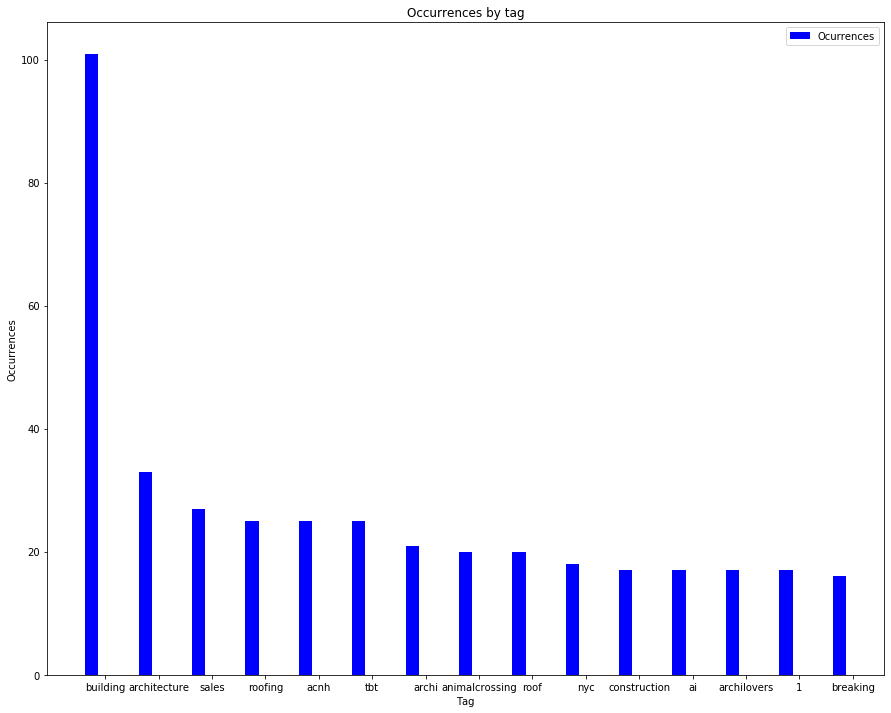

In [74]:
# Count frequency of words
tags=textdata['tag'].tolist()
tags= [item for sublist in tags for item in sublist]
counter=collections.Counter(tags)
counter_data=counter.most_common(display_n_words)

# Plot most used tags
n_groups = len(counter_data)

vals_films = [x[1] for x in counter_data]
legends_films = [x[0] for x in counter_data]
index = np.arange(n_groups)
bar_width = 0.25


fig, ax = plt.subplots(figsize=(15,12))
plt.xlabel('Tag')
plt.bar(index, vals_films, bar_width,color='b',label='Ocurrences')
plt.ylabel('Occurrences')
plt.title('Occurrences by tag')
plt.xticks(index + bar_width, legends_films)
plt.legend()

In [92]:
# Count mean no of tokens/words by hashtag
#textdata['no_of_token']=textdata['text'].apply(lambda x: len(x.split()))
#textdata.groupby(['tag']).agg({'no_of_token':'mean'}).sort_values(by=['no_of_token'],ascending=False).plot(kind='bar')

#### Show words most used in tweeter bigger size==more used

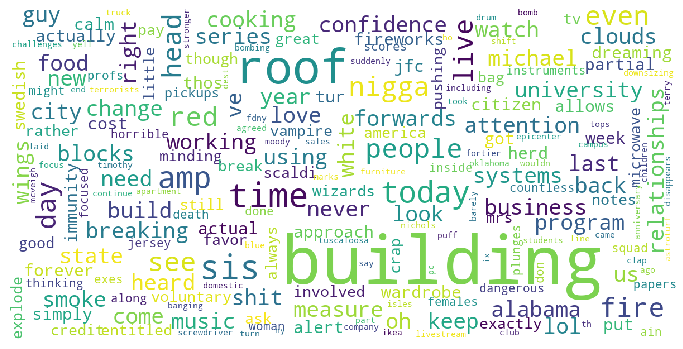

In [75]:
# create wordcloud
stopwords_set = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords_set,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(textdata['text'])

#### Locationwise number of tweets

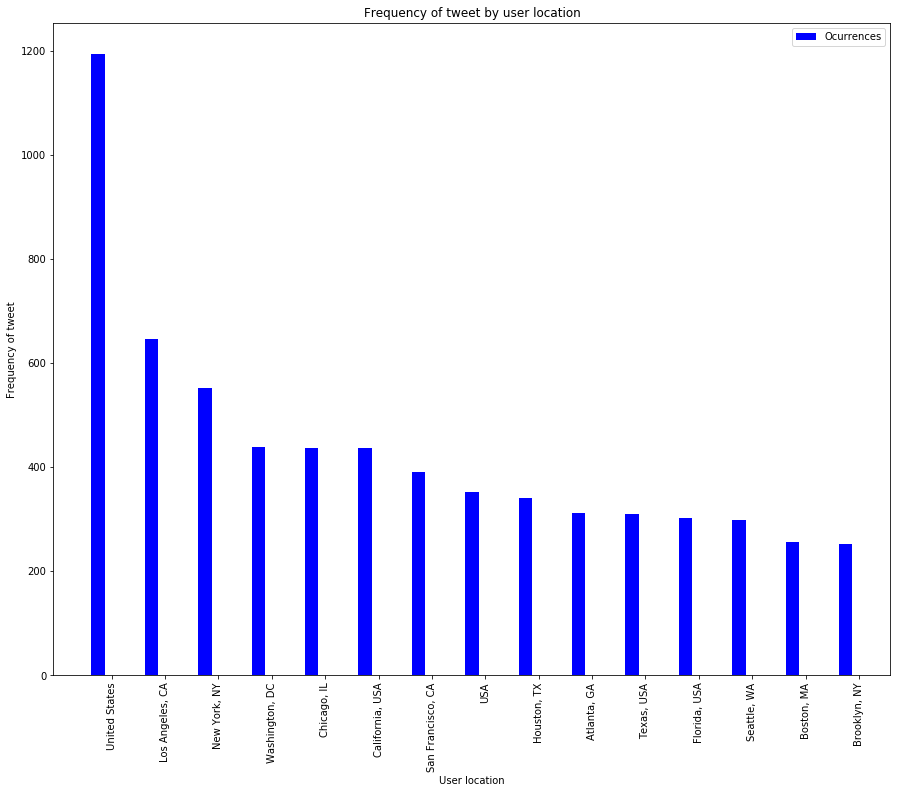

In [93]:
# Count frequency of words
user_l=textdata['user_location'].tolist()
#user_l= [item for sublist in user_l for item in sublist]
counter=collections.Counter(user_l)
counter_data=counter.most_common(display_n_words)

# Plot most used tags
n_groups = len(counter_data)

vals_films = [x[1] for x in counter_data]
legends_films = [x[0] for x in counter_data]
index = np.arange(n_groups)
bar_width = 0.25


fig, ax = plt.subplots(figsize=(15,12))
plt.xlabel('User location')
plt.bar(index, vals_films, bar_width,color='b',label='Ocurrences')
plt.ylabel('Frequency of tweet')
plt.title('Frequency of tweet by user location')
plt.xticks(index + bar_width, legends_films,rotation='vertical')
plt.legend()

#### Datewise total tweet

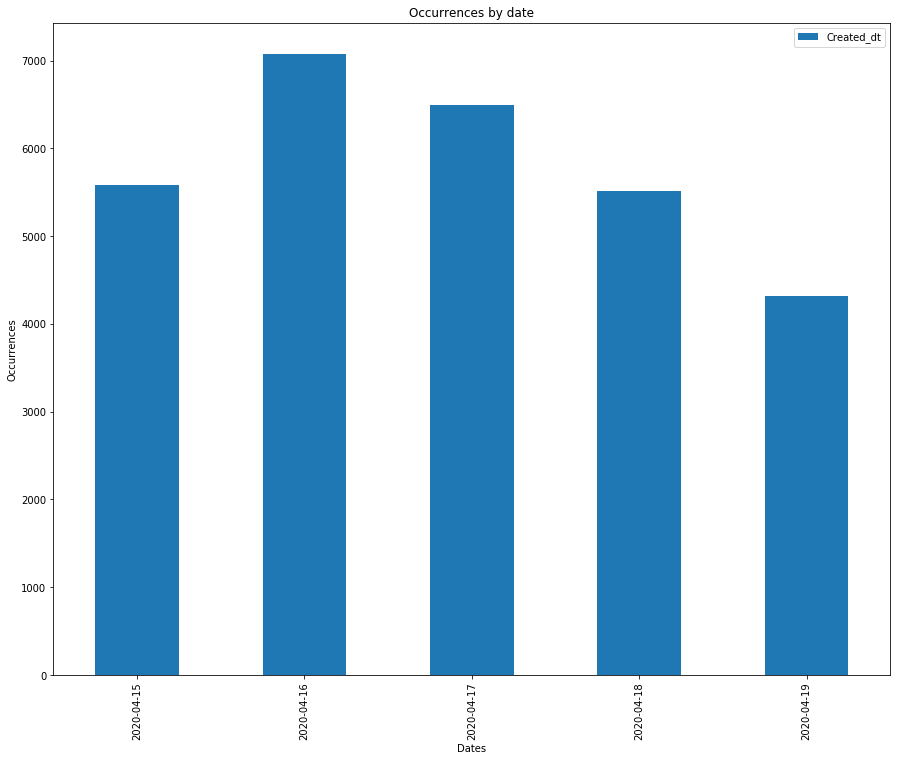

In [106]:
textdata['Created_dt']=textdata['Created'].apply(lambda x: pd.to_datetime(x).date())
fig, ax = plt.subplots(figsize=(15,12))
plt.xlabel('Dates')
plt.ylabel('Occurrences')
textdata['Created_dt'].value_counts().sort_index().plot(ax=ax, kind='bar')
plt.title('Occurrences by date')
plt.legend()

## ML model
#### Here we are trying to get the most discussed topic in twitter. Say we want to identify 10 topic across the data available in twitter for the searchstrings. Once we get the topics we will show the top 10 important words of each topics. By displaying those top 10 words in each topic we can get some idea what people are talking about in twitter which might benifit the business.

## Create vector form of text data
#### We convert text to vector for applying machine learning model

In [107]:
# Initialise the count vectorizer
count_vectorizer = CountVectorizer(min_df = 3)

# Fit and transform the processed text
count_data = count_vectorizer.fit_transform(textdata['text'])

# Initialise the tfidf vectorizer 
tfidf_vectorizer = TfidfVectorizer(min_df=3)

# Fit and transform the processed text
tfidf_data = tfidf_vectorizer.fit_transform(textdata['text'])

### Hyperparameter for 3 models user input this is for tunning for ML model

In [154]:
search_params_lda = {'n_components': [10], 'doc_topic_prior':[.1],'topic_word_prior':[.1],'learning_decay': [.5,.8,1]} # learning_decay between .5 and 1
search_params_nmf = {'n_components': [10], 'alpha':[.1,.5,.8], 'l1_ratio':[.5,.8,1]} # with 10 n_component model perplexity 20000
#search_params_gensim={'num_topics':[10],'alpha':['asymmetric','auto',.1],'eta':[.1]}               
search_params_gensim={'num_topics':[10],'alpha':['auto','asymmetric',.1,.3],'eta':[.1,.3,.5]}               


## Use LDA model for topic modelling

#### Use countvectorizer
#### Careful: Below steps will take time
#### Below interactive plot will show the importants words(right side) for a topic(left side circle) if cursor is placed on a topic.

Best model's params:  {'doc_topic_prior': 0.1, 'learning_decay': 0.8, 'n_components': 10, 'topic_word_prior': 0.1}
Best log likelihood score:  -452048.2253138085
Model perplexity:  2853.948148550444
Using best model below are topics and top n words

Topic #0:
building gaf go like shit get really never know feel people say could still going

Topic #1:
building roof built st one year anxiety old floor day bed new today friend apartment

Topic #2:
building team great something work world people know love talk new time build system business

Topic #3:
building state city home new work keep april capitol year today pm th back federal

Topic #4:
building amp business new start find brand time make line pick one small check good

Topic #5:
building like people look would thing think lot time house one year get need day

Topic #6:
building roof top time one every better day going get new way need game lol

Topic #7:
building fire music roof one first amp new need moody hall nfl see smoke apart

C:\Users\suman12345678\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


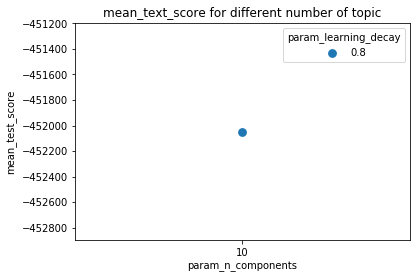

In [161]:
# do grid search and return best model for LDA
def modelcall(model_name,data,search_params):
    model = GridSearchCV(model_name, search_params)
    model.fit(data)   
    best_lda_model = model.best_estimator_
    print("Best model's params: ", model.best_params_)
    print("Best log likelihood score: ", model.best_score_)
    print("Model perplexity: ", best_lda_model.perplexity(data))
    return model

def model_score(model,count_vectorizer,count_data,n_top_words=15):

    # Topic - Keyword matrix
    best_lda_model = model.best_estimator_
    df_topic_keywords = pd.DataFrame(best_lda_model.components_)

    # assign column and index
    df_topic_keywords.columns = count_vectorizer.get_feature_names()
    topicnames = ['Topic_' + str(i) for i in range(best_lda_model.n_components)]
    df_topic_keywords.index = topicnames
    
    words = count_vectorizer.get_feature_names()
    print('Using best model below are topics and top n words')
    # Topic numberring below and in pyLDAvis may be different
    for topic_idx, topic in enumerate(best_lda_model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))    

    # check the head
    df_topic_keywords.iloc[:,:10]

    df_cv_results = pd.DataFrame(model.cv_results_)
    
    # plot cross validation result
    sns.pointplot(x="param_n_components", y="mean_test_score", hue="param_learning_decay", data=df_cv_results).set_title('mean_text_score for different number of topic')
    
    # refered from https://shravan-kuchkula.github.io/topic-modeling/#appendix
    best_lda_model = model.best_estimator_
    panel = pyLDAvis.sklearn.prepare(best_lda_model, count_data, count_vectorizer, mds='tsne')
    vis=pyLDAvis.display(panel)
    return vis

#search_params_lda = {'n_components': [5], 'learning_decay': [.2]}  # with n_component=10 model_perplexity 2550. Lowest perplexity is best
model_name = LDA( n_jobs=-1)
final_model_lda_cv=modelcall(model_name,count_data,search_params_lda)
final_model_lda_cv_vis=model_score(final_model_lda_cv,count_vectorizer,count_data,n_top_words=display_n_words)
final_model_lda_cv_vis

#### Use tfidf
#### Careful: Below steps will take time
#### Below interactive plot will show the importants words(right side) for a topic(left side circle) if cursor is placed on a topic.

Best model's params:  {'doc_topic_prior': 0.1, 'learning_decay': 0.8, 'n_components': 10, 'topic_word_prior': 0.1}
Best log likelihood score:  -211260.69686124465
Model perplexity:  22945.588718954692
Using best model below are topics and top n words

Topic #0:
building capitol roof one state today protest people get new jump would time nfl next

Topic #1:
building roof head family food like people amp health time know grateful day around still

Topic #2:
building roof anxiety wwe federal murrah city people year oklahoma like know bombing get ago

Topic #3:
building rent new pay roof one apartment month michael che amp time day public empire

Topic #4:
building roof get like need keep go one let know people amp time thing would

Topic #5:
building roof home new like look amp business people start one time dream church need

Topic #6:
building one roof people great work gt like amp team new time want year get

Topic #7:
building roof gaf lol really like new one pick nobody going get top

C:\Users\suman12345678\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


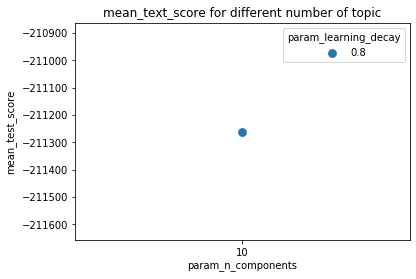

In [156]:
model_name = LDA(n_jobs=-1)
final_model_lda_tf=modelcall(model_name,tfidf_data,search_params_lda)
final_model_lda_tf_vis=model_score(final_model_lda_tf,tfidf_vectorizer,tfidf_data)
final_model_lda_tf_vis

## Use NMF(Non Matrix factorization) model for topic modelling

#### Use countvectorizer
#### Careful: Below steps will take time

In [157]:


# Grid search
def gridsearch_nmf(search_params,count_data,count_vectorizer,n_top_words):
    error=1000000

    for i in search_params['n_components']:
        for j in search_params['alpha']:
            for k in search_params['l1_ratio']:
                #print('for ',i,j,k)
                model_name=NMF(n_components=i,alpha=j,l1_ratio=k)
                model_name.fit(count_data)
                #print(model_name.reconstruction_err_)
                if model_name.reconstruction_err_<error:
                    error=model_name.reconstruction_err_
                    #print('Better model',model_name.reconstruction_err_,i,j,k)
                    final_model=model_name
    words = count_vectorizer.get_feature_names()
    print('From grid search best model reconstraction error',final_model.reconstruction_err_,' with number of topic ',final_model.n_components)
    print('For best model topics and top n words with their weights')
    for topic_idx, topic in enumerate(final_model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]+" "+str(topic[i])
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))   
        
    return final_model
    
        
#search_params = {'n_components': [5], 'alpha':[0.0], 'l1_ratio':[0.0]} # with 10 n_component model perplexity 20000
final_model_nmf_cv=gridsearch_nmf(search_params=search_params_nmf,count_data=count_data,count_vectorizer=count_vectorizer,n_top_words=display_n_words)


From grid search best model reconstraction error 470.7975429402328  with number of topic  10
For best model topics and top n words with their weights

Topic #0:
building 18.563261574551664 apartment 0.430203665020618 fire 0.37056082248879835 team 0.37020264799475006 world 0.3686486766109261 start 0.3613944264496673 work 0.3371806695183644 right 0.3312132033404415 community 0.32872245245896675 great 0.3225932059245215 around 0.3220409114168895 state 0.2950879833778693 house 0.2948864855566125 keep 0.29421935742794836 home 0.2905541754931793

Topic #1:
roof 13.194329458342928 head 1.3839698759924064 anxiety 0.511618939918781 go 0.4688248430072216 food 0.46235984540587466 top 0.4598716931126377 family 0.44906502169331025 would 0.39273646482013447 still 0.3247137895550894 need 0.3223526691311096 going 0.3056809892563031 got 0.2997295653769998 house 0.29112922853727113 right 0.28540941509876344 home 0.28521114936281816

Topic #2:
like 10.803929585550334 gaf 1.373692119055669 look 1.36929557

#### tfidf vectorizer
#### Careful: Below steps will take time

In [158]:

final_model_nmf_tf=gridsearch_nmf(search_params=search_params_nmf,count_data=tfidf_data,count_vectorizer=tfidf_vectorizer,n_top_words=display_n_words)

From grid search best model reconstraction error 167.13287892736113  with number of topic  10
For best model topics and top n words with their weights

Topic #0:
building 8.938262274603805 apartment 0.5182559437894421 fire 0.48082112975844166 world 0.4795925153393083 love 0.47889344069677686 team 0.4671079741491054 start 0.44981053099628027 work 0.4435668601464199 home 0.43769976506209807 house 0.43370760506664086 great 0.4295989234037437 right 0.42636702571531115 wall 0.405011398924302 keep 0.3936016654986687 around 0.38379488032726455

Topic #1:
roof 7.8606853899053215 anxiety 0.9185518585531824 top 0.41965576451410747 head 0.3603136716760964 thru 0.31152352464843974 jump 0.2551119860225962 go 0.2304075203265202 mouth 0.22010181735641401 right 0.2183725234659266 going 0.21724913633456958 fucking 0.19407155057068787 would 0.1916755414508071 day 0.18254151883657427 level 0.18043047608259258 got 0.16548100930130696

Topic #2:
gaf 5.58930526072153 really 0.9519473863050458 ion 0.92799249


    
## Use gensim model    
#### Create text corpus

In [159]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(textdata['text']))

print(data_words[:1])

id2word = corpora.Dictionary(data_words)

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_words]

# View
print(corpus[:1])

[['last', 'week', 'heard', 'firework', 'forever', 'like', 'jfc', 'calm', 'got', 'citizen', 'alert', 'tur']]
[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1)]]


#### Grid search
#### Careful: Below steps will take time

In [160]:
def gensin_gs(search_params,corpus,data_words):
    perplixity=100000
    coherance=0
    for i in search_params['num_topics']:
        for j in search_params['alpha']:
                for k in search_params['eta']:
                        lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=i, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha=j,
                                           eta=k,                         
                                           per_word_topics=True)
                        doc_lda = lda_model[corpus]
                        
                        # Compute Coherence Score
                        coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words, dictionary=id2word, coherence='c_v')
                        # compute perplexist
                        ps=lda_model.log_perplexity(corpus)
                        with np.errstate(invalid='ignore'):
                            coherence_lda = coherence_model_lda.get_coherence()
                        print('/n/nFor topics, alpha, eta values : ',i,j,k)    
                        print('Perplexity: ', ps,'\nCoherence Score: ', coherence_lda)  # a measure of how good the model is. lower the better.

                        if (coherence_lda>coherance):  # & (ps <perplixity):
                            final_model=lda_model

    pyLDAvis.enable_notebook()
    vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)

    return final_model, vis    

final_model_gensim,final_model_gensim_vis=gensin_gs(search_params_gensim,corpus,data_words)
final_model_gensim_vis


/n/nFor topics, alpha, eta values :  10 auto 0.1
Perplexity:  -9.798518309972428 
Coherence Score:  0.3552779029663077


C:\Users\suman12345678\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.356299  0.250997       1        1  20.200535
5      0.212164 -0.378621       2        1  19.982332
4     -0.051705  0.015272       3        1  10.541686
0     -0.055804  0.016349       4        1  10.166987
3     -0.048922  0.015152       5        1   9.920504
9     -0.072094  0.015815       6        1   7.951683
2     -0.074368  0.016975       7        1   7.902193
7     -0.088856  0.016576       8        1   5.128030
6     -0.088139  0.016165       9        1   4.897948
8     -0.088575  0.015320      10        1   3.308094, topic_info=     Category          Freq          Term         Total  loglift  logprob
15    Default  16786.000000      building  16786.000000  30.0000  30.0000
72    Default   3767.000000          roof   3767.000000  29.0000  29.0000
177   Default   1357.000000        people   1357.000000  28.0000  28.0000
63    Default   1559.000000           amp   1559.000000  27.0000  27.0000
192   Default   1378.000000          time   1378.000000  26.0000  26.0000
9     Default   1965.000000          like   1965.000000  25.0000  25.0000
287   Default   1871.000000           new   1871.000000  24.0000  24.0000
41    Default   1116.000000           get   1116.000000  23.0000  23.0000
232   Default   1224.000000           day   1224.000000  22.0000  22.0000
150   Default   1114.000000         today   1114.000000  21.0000  21.0000
545   Default   1460.000000           one   1460.000000  20.0000  20.0000
335   Default    928.000000          know    928.000000  19.0000  19.0000
375   Default    814.000000            go    814.000000  18.0000  18.0000
235   Default    769.000000        really    769.000000  17.0000  17.0000
391   Default   1087.000000           gaf   1087.000000  16.0000  16.0000
201   Default    759.000000          head    759.000000  15.0000  15.0000
153   Default    746.000000          year    746.000000  14.0000  14.0000
763   Default   1061.000000          need   1061.000000  13.0000  13.0000
284   Default    469.000000         first    469.000000  12.0000  12.0000
518   Default    631.000000          help    631.000000  11.0000  11.0000
402   Default    980.000000         would    980.000000  10.0000  10.0000
1937  Default    663.000000           lol    663.000000   9.0000   9.0000
78    Default    584.000000          good    584.000000   8.0000   8.0000
76    Default    583.000000          even    583.000000   7.0000   7.0000
564   Default    903.000000         think    903.000000   6.0000   6.0000
293   Default    568.000000          back    568.000000   5.0000   5.0000
57    Default    628.000000          keep    628.000000   4.0000   4.0000
58    Default    626.000000          live    626.000000   3.0000   3.0000
5     Default    555.000000           got    555.000000   2.0000   2.0000
687   Default    463.000000          look    463.000000   1.0000   1.0000
...       ...           ...           ...           ...      ...      ...
284   Topic10    468.631866         first    469.563477   3.4068  -2.9173
1123  Topic10    278.242004    everything    279.173828   3.4055  -3.4386
809   Topic10    263.897461          hear    264.829376   3.4053  -3.4915
1484  Topic10    252.356689        series    253.288651   3.4051  -3.5362
643   Topic10    214.670074          sure    215.601669   3.4045  -3.6980
1616  Topic10    213.608795           use    214.540436   3.4044  -3.7029
1352  Topic10    197.648331          wall    198.579941   3.4041  -3.7806
836   Topic10    194.492249        making    195.423874   3.4040  -3.7967
796   Topic10    174.281982          list    175.213623   3.4035  -3.9064
523   Topic10    153.756287          stop    154.687881   3.4028  -4.0317
1201  Topic10    149.885483         skill    150.817108   3.4026  -4.0572
1456  Topic10    131.106308        pretty    132.037933   3.4017  -4.1911
971   Topic10    122.236404          nice    123.1680

#### Below interactive plot will show the importants words(right side) for a topic(left side circle) if cursor is placed on a topic.

In [ ]:
#final_model_gensim = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=10, random_state=100,
#                                           update_every=1,chunksize=100,passes=10,alpha='auto',eta=.5, per_word_topics=True)
#pyLDAvis.enable_notebook()
#vis = pyLDAvis.gensim.prepare(final_model_gensim, corpus, id2word)
#vis


## Conclusions
#### In this analysis we tried to identify 10 most important topics discussed in twitter from 16-04-2020 to 20-04-2020 by looking into twitter text in USA location, And for each topic 15 most important words are shown above. The intention is to help business by showing this analysis. 
#### This script can be used for identifying topics from any keyword text and any date and any location by changing parameters.
#### As we are aware currently the whole world is talking about COVID-19, so its bit difficult to get other sensible topic related to roofing excluding COVID-19 related texts, which leave us only few tweets.
#### We can also use some other Machile learning algorithm to help business.
#### Depanding on good selection of text we are looking in twitter the performance of model will improve.
#### This analysis can show better result with better infracture of CPU/cloud and using more data points. This analysis is based on 30k data points and model building is not optimize, this is just to display initial result
